In [34]:
nb_samples = 64
# list_features = ["longitude", "latitude", "groundspeed"] #, "track"] #, "altitude"]
# list_features = ["longitude", "latitude", "track"] #, "track"] #, "altitude"]
list_features = ["longitude", "latitude"]  # , "track"] #, "altitude"]
nb_features = len(list_features)

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from traffic.core import Flight, Traffic
from traffic.algorithms.clustering import prepare_features
from traffic.data import airports

import wandb

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.max_columns", None)

t = Traffic.from_file("./data/resampled_t_near_ap.parquet")
t.data.head()

airport = airports["LSZH"]

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from artefact import Autoencoder
from artefact.clustering import get_latent
from artefact.training import train
from artefact.plot import plot_loss, plot_latent, plot_latent_and_trajs

np.random.seed(0)

torch.manual_seed(0)

In [140]:
t.data["runway_name"].value_counts()

runway_name
28    167488
32     70400
16     32960
10      7168
34      5632
14        64
Name: count, dtype: int64

In [38]:
t_f = Traffic(t.data.copy())
t_f = t_f.query("runway_name == '28'")

In [39]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = MinMaxScaler(feature_range=(0, 1))

features = t_f.data[list_features].values  # type: ignore
scaler = scaler.fit(features)  # fits on the axis 0

features = scaler.transform(features)
features_shape = features.shape
X = features.ravel()
print(f"X shape: {X.shape}")
print(f"features shape: {features_shape}")
print(f"scaler data min: {scaler.data_min_}, max: {scaler.data_max_}, range: {scaler.data_range_}")

X shape: (334976,)
features shape: (167488, 2)
scaler data min: [ 8.544617 47.440933], max: [ 8.570503 47.467678], range: [0.025886 0.026745]


In [40]:
def prepare_features_new(
    *,
    list_features,
    scaler: MinMaxScaler,
    traffic: Traffic,
    flight_idx: list[str] | None = None,
    nb_samples: int = 64,
):
    if flight_idx is not None:
        traffic = traffic[flight_idx]  # type: ignore

    X = np.empty((len(traffic), nb_samples * len(list_features)))
    flight_idx_order = []
    for idx, flight in enumerate(traffic):
        # _X = np.empty((len(list_features), nb_samples))

        _X_unscaled = flight.data[list_features]

        _X = scaler.transform(_X_unscaled)

        X[idx] = _X.reshape(-1)
        flight_idx_order.append(flight.flight_id)

    return X, flight_idx_order

In [41]:
X, *_ = prepare_features_new(list_features=list_features, scaler=scaler, traffic=t_f)
display(X)
X.shape

array([[-0.1233099 ,  0.59521406, -0.13659893, ...,  0.17674332,
         0.86633702,  0.18003365],
       [-0.16843081,  0.6174986 , -0.17569343, ...,  0.27141522,
         0.72077571,  0.27141522],
       [-0.13791239,  0.61061881, -0.14579309, ...,  0.17584595,
         0.87035463,  0.18003365],
       ...,
       [-0.04921579,  0.00512245, -0.04643437, ...,  0.17741634,
         0.91393031,  0.1783137 ],
       [-0.09549563, -0.00213124, -0.09147802, ...,  0.17569639,
         0.90303639,  0.1783137 ],
       [ 0.05833269,  0.05522528,  0.07185351, ...,  0.17928585,
         0.96291432,  0.18018321]])

(2617, 128)

In [42]:
from pathlib import Path


def plot_reconstruction(
    flight_selection: list[str],
    traffic: Traffic,
    model: Autoencoder,
    save_dir: Path = Path("./data/plots/reconstructions/"),
    show_plots=False,
):
    features, flight_selection = prepare_features_new(
        list_features=list_features, scaler=scaler, traffic=t_f, flight_idx=flight_selection
    )

    features = torch.as_tensor(features, dtype=torch.float32, device="cpu")

    figures: list[plt.Figure] = []  # type: ignore

    model.to("cpu")
    model.eval()

    with torch.no_grad():
        lat, output = model(features)
        lat = lat.cpu().numpy()
        output = output.cpu().numpy()

    for i, flight_id in enumerate(flight_selection):
        flight_original = traffic[flight_id]

        flight_output = output[i].reshape(-1, len(list_features))
        flight_output = scaler.inverse_transform(flight_output)

        flight_reconstructed = Flight(flight_original.data.copy())
        flight_reconstructed.data[list_features] = flight_output

        with plt.style.context("traffic"):  # type: ignore
            fig, ax = plt.subplots(figsize=(7, 7))

            flight_original.plot(ax, alpha=0.5, label="original", color="green", ls="--")
            flight_reconstructed.plot(ax, alpha=0.5, label="reconstructed", color="k")
            plt.title(f"{flight_original.flight_id}")
            # print(flight_original.flight_id)
            # plt.show()
            plt.savefig(save_dir / f"{flight_original.flight_id}.png")

            figures.append(fig)

            if show_plots:
                plt.show()
            plt.close()
    
    return figures

In [145]:
X = np.nan_to_num(X, nan=0.0)
X.dtype
X = X.astype(np.float32)

In [43]:
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm.autonotebook import tqdm


def train(
    model,
    X,
    device,
    batch_size=1000,
    lambda_kl=0.0,
    distance_trajectory="euclidean",
    lr=1e-3,
    weight_decay=1e-5,
    epochs=5000,
):
    model.to(device)
    model.train()
    with torch.enable_grad():
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        dataset = TensorDataset(torch.Tensor(X))
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            sampler=None,
            drop_last=True,
            num_workers=6,
        )

        loss_evolution, re_evolution, kl_evolution = [], [], []
        epoch_loss = []

        for epoch in tqdm(range(epochs)):
            epoch_loss.append(0)

            for batch in tqdm(dataloader, desc="batches", leave=False, unit="batch"):
                optimizer.zero_grad()

                v = batch[0].to(device)

                # for iteration in tqdm(range(nb_iterations), leave=False):

                lat, output = model(v)
                # distance = nn.MSELoss(reduction="none")(output, v).sum(1).sqrt()

                loss = criterion(output, v)

                loss_evolution.append(loss.cpu().item())

                loss.backward()
                optimizer.step()

                epoch_loss[-1] += loss.cpu().item()

            # print(f"Epoch {epoch} loss: {epoch_loss[-1]}")

    return (
        model,
        {"loss": loss_evolution, "re_loss": re_evolution, "kl_loss": kl_evolution, "epoch_loss": epoch_loss},
    )

In [64]:
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm.autonotebook import tqdm


def train_(
    model,
    X,
    device,
    nb_iterations,
    batch_size=1000,
    lambda_kl=0.0,
    distance_trajectory="euclidean",
    lr=1e-3,
    weight_decay=1e-5,
    epochs=1,
):
    model.to(device)
    model.train()
    with torch.enable_grad():
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        dataset = TensorDataset(torch.Tensor(X))
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            sampler=None,
            num_workers=4,
        )

        loss_evolution, re_evolution, kl_evolution = [], [], []

        for batch in tqdm(dataloader, desc="batches", leave=True, unit="batch"):
            # print(batch)
            v = batch[0].to(device)

            # if lambda_kl > 0:
            #     P = torch.as_tensor(make_P(batch[0], metric=distance_trajectory), device=device, dtype=torch.float32)

            for iteration in tqdm(range(nb_iterations), leave=True):
                lat, output = model(v)
                # distance = nn.MSELoss(reduction="none")(output, v).sum(1).sqrt()

                loss = criterion(output, v)

                # if lambda_kl > 0:
                #     kl = kl_divergence(lat, P)
                #     re_evolution.append(loss.cpu().item())
                #     kl_evolution.append(kl.cpu().item())
                #     loss += lambda_kl * kl

                loss_evolution.append(loss.cpu().item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if wandb.run is not None:
                    wandb.log({"loss": loss_evolution[-1]})

    return (
        model,
        {"loss": loss_evolution, "re_loss": re_evolution, "kl_loss": kl_evolution},
    )

In [45]:
flight_selection = ["SWR641U_4038", "SWR101C_1466", "THY4341_6440", "PGT7114_6603", "SWR1326_6227"]

In [1]:
import os

print(os.environ["MLFLOW_TRACKING_URI"], os.environ["MLFLOW_TRACKING_USERNAME"])

https://mlapp-nkxq44f73a-ez.a.run.app admin-science


In [57]:
class AutoencoderDieu(nn.Module):
    def build_encoder(self, dims, reluout=True):
        ret = []
        n = len(dims[:-1])
        for i, (n1, n2) in enumerate(zip(dims[:-1], dims[1:])):
            ret.append(nn.Linear(n1, n2))
            # ret.append(nn.Dropout(dropout))
            if i < n - 1 or reluout:
                ret.append(self.relu)

        return ret

    def build_decoder(self, dims):
        ret = []
        n = len(dims[:-1])
        for i, (n1, n2) in enumerate(zip(dims[:-1], dims[1:])):
            ret.append(nn.Linear(n1, n2))
            # ret.append(nn.Dropout(dropout))
            if i < n - 1:
                ret.append(self.relu)

        return ret

    def __init__(self, layers, relu=None, output_layer=nn.Sigmoid(), reluout = True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        if relu is not None:
            self.relu = relu
        else:
            self.relu = nn.ReLU()
        # self.relu = nn.PReLU()

        arch_encoder = layers
        arch_decoder = tuple(reversed(layers))

        self.encoder = nn.Sequential(*self.build_encoder(arch_encoder, reluout))
        self.decoder = nn.Sequential(*self.build_decoder(arch_decoder), output_layer)

        print("encoder", self.encoder)
        print("decoder", self.decoder)

    def forward(self, x, **kwargs):
        lat = self.encoder(x)
        output = self.decoder(lat)
        return lat, output

encoder Sequential(
  (0): Linear(in_features=128, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=32, out_features=8, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=8, out_features=2, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=32, out_features=128, bias=True)
  (5): Tanh()
)


batches:   0%|          | 0/1 [00:00<?, ?batch/s]

[tensor([[ 0.1923,  0.1228,  0.1929,  ...,  0.1739,  0.9424,  0.1757],
        [-0.1281,  0.0530, -0.1140,  ...,  0.1767,  0.8894,  0.1791],
        [-0.1233,  0.6081, -0.1458,  ...,  0.1748,  0.9496,  0.1750],
        ...,
        [-0.1300, -0.1562, -0.1247,  ...,  0.1750,  0.9284,  0.1767],
        [-0.0424,  0.0356, -0.0410,  ...,  0.1767,  0.9044,  0.1791],
        [-0.1631,  0.0715, -0.1327,  ...,  0.1785,  0.8962,  0.1791]])]


  0%|          | 0/5000 [00:00<?, ?it/s]

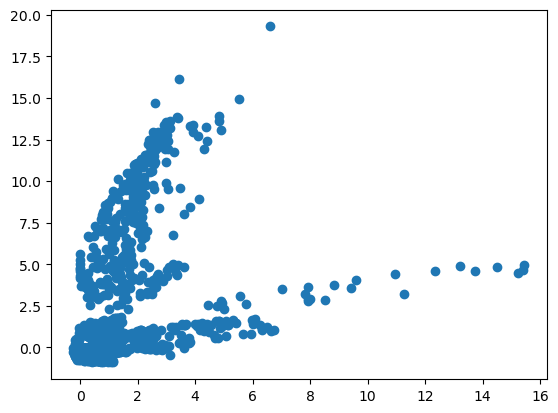

loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00467


In [89]:
# import os


# mlflow.set_tracking_uri("https://mlapp-nkxq44f73a-ez.a.run.app")

# experiment = wandb.init(project="trajectory_autoencoder", name="test2")

device = "cpu"

nb_iterations = 5000
batch_size = X.shape[0]
lambda_kl = 0
lr = 5e-3
weight_decay = 1e-5

config = {
    "nb_samples": nb_samples,
    "nb_features": nb_features,
    "nb_iterations": nb_iterations,
    "batch_size": batch_size,
    "lambda_kl": lambda_kl,
    "n_flights": len(t_f),
    # "distance_trajectory": distance_trajectory,
    "lr": lr,
    "weight_decay": weight_decay,
    # "epochs": epochs,
}

np.random.seed(0)

torch.manual_seed(0)

run_name = "3aout_tanh_scaler-1_1_custom_ae_leaky_relu_small_ReluOut"
with wandb.init(project="trajectory_autoencoder", name=run_name, config=config) as experiment:  # type: ignore
    # model_ = Autoencoder((nb_samples * nb_features, 32, 8, 2), leaky=False)
    # relu = nn.Mish()
    relu = nn.LeakyReLU()
    # model_ = AutoencoderDieu((nb_samples * nb_features, 64, 32, 8, 2), relu=relu)
    model_ = AutoencoderDieu((nb_samples * nb_features, 32, 8, 2), relu=relu, output_layer=nn.Tanh(), reluout=True)

    wandb.config["encoder"] = str(model_.encoder)
    wandb.config["decoder"] = str(model_.decoder)

    model_, metrics = train_(
        model_,
        X,
        device,
        nb_iterations,
        batch_size,
        lambda_kl,
        # distance_trajectory,
        lr=lr,
        weight_decay=weight_decay,
        # epochs,
    )

    # wandb.log({"last_loss": metrics["loss"][-1]})
    # wandb.log({"loss": metrics["loss"]})

    if True:
        latent = get_latent(X, model_, device)

        fig = plt.figure()
        # ax = fig.add_subplot(projection='3d')
        ax = fig.add_subplot()
        # ax.scatter(latent[:, 0], latent[:, 1],c=latent[:, 2])
        # ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2])
        ax.scatter(latent[:, 0], latent[:, 1])
        plt.savefig(f"./data/plots/latent/{wandb.run.name}.png")

        wandb.log({"latent_space": wandb.Image(fig)})
        wandb.log({"latent": latent})
        plt.show()
        plt.close()
        # wandb.log_artifact(f"./data/plots/latent/{wandb.run.name}.png")

    if True:
        img_save_path = Path(f"./data/plots/reconstructions/{wandb.run.name}/")
        img_save_path.mkdir(parents=True, exist_ok=True)
        figs = plot_reconstruction(flight_selection, t_f, model_, img_save_path)
        # wandb.log_artifact(img_save_path)
        wandb.log({"reconstructions": [wandb.Image(fig) for fig in figs]})

In [65]:
# model_ = Autoencoder((nb_samples * nb_features, 64, 32, 8, 2))
# model_ = Autoencoder((nb_samples * nb_features, 32, 8, 2), dropout=0.1)
model_ = Autoencoder((nb_samples * nb_features, 64, 32, 8, 2))

device = "cpu"
device = "mps"
# model, loss = train(
#     # model_, X, device=device, nb_iterations=5000, batch_size=len(X), lambda_kl=0, epochs=1, distance_trajectory="euclidean"
#     model_,
#     X,
#     device=device,
#     # nb_iterations=5000,
#     # batch_size=len(X),
#     lambda_kl=0,
#     epochs=100,
#     # batch_size=500,
#     batch_size=X.shape[0],
#     lr=1e-3,
#     # distance_trajectory="directed_hausdorff"
#     # model_, X, device=device, nb_iterations=5000, batch_size=len(X), lambda_kl=0, epochs=3, distance_trajectory="euclidean"
# )

model, loss = train_(
    # model_, X, device=device, nb_iterations=5000, batch_size=len(X), lambda_kl=0, epochs=1, distance_trajectory="euclidean"
    model_,
    X,
    device=device,
    nb_iterations=10000,
    # nb_iterations=5000,
    # batch_size=len(X),
    # batch_size=500,
    batch_size=X.shape[0],
    # distance_trajectory="directed_hausdorff"
    # model_, X, device=device, nb_iterations=5000, batch_size=len(X), lambda_kl=0, epochs=3, distance_trajectory="euclidean"
)

encoder Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=2, bias=True)
  (7): ReLU()
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=128, bias=True)
  (7): Tanh()
)


batches:   0%|          | 0/1 [00:00<?, ?batch/s]

[tensor([[ 0.1671, -0.1228,  0.1565,  ...,  0.1757,  0.8744,  0.1809],
        [-0.5239,  0.5203, -0.5375,  ...,  0.1750,  0.9479,  0.1748],
        [ 0.0923, -0.0027,  0.0929,  ...,  0.1750,  0.9465,  0.1748],
        ...,
        [-0.0835, -0.0638, -0.0859,  ...,  0.1023,  0.8581,  0.1026],
        [ 0.1207, -0.3085,  0.1195,  ...,  0.1748,  0.9417,  0.1750],
        [-0.1406, -0.1202, -0.1362,  ...,  0.1757,  0.8935,  0.1791]])]


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [51]:
model_ = Autoencoder((nb_samples * nb_features, 64, 32, 8, 2))

device = "cpu"
model, loss = train(
    model_,
    X,
    device=device,
    nb_iterations=10000,
    batch_size=len(X),
    lambda_kl=0,
    epochs=1,
    distance_trajectory="euclidean",
)

dropout!
encoder Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Dropout(p=0.25, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=8, bias=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=2, bias=True)
  (10): Dropout(p=0.25, inplace=False)
  (11): ReLU()
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=32, bias=True)
  (4): Dropout(p=0.25, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=64, bias=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=128, bias=True)
  (10): Dropout(p=0.25, inplace=False)
  (11): Sigmoid()
)


  0%|          | 0/1 [00:00<?, ?it/s]

batches:   0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [90]:
model = model_
model.to(device)
model.eval()

AutoencoderDieu(
  (relu): LeakyReLU(negative_slope=0.01)
  (encoder): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=128, bias=True)
    (5): Tanh()
  )
)

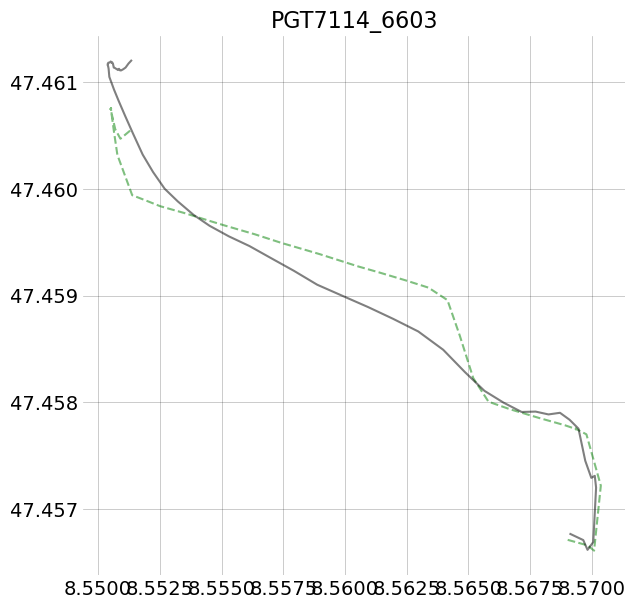

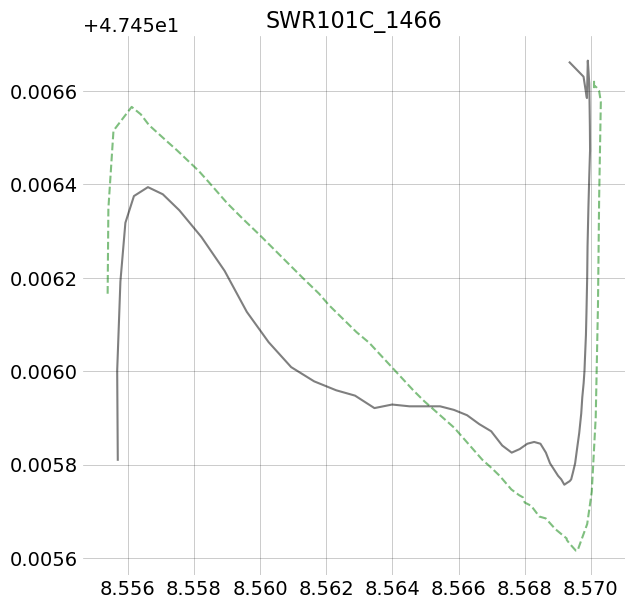

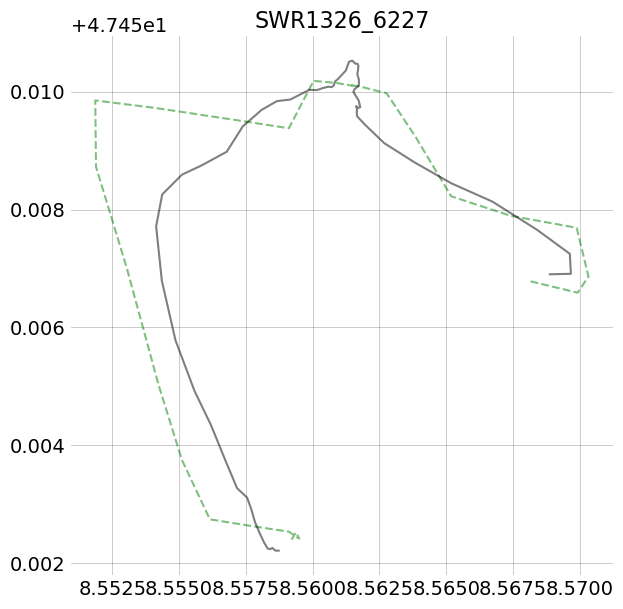

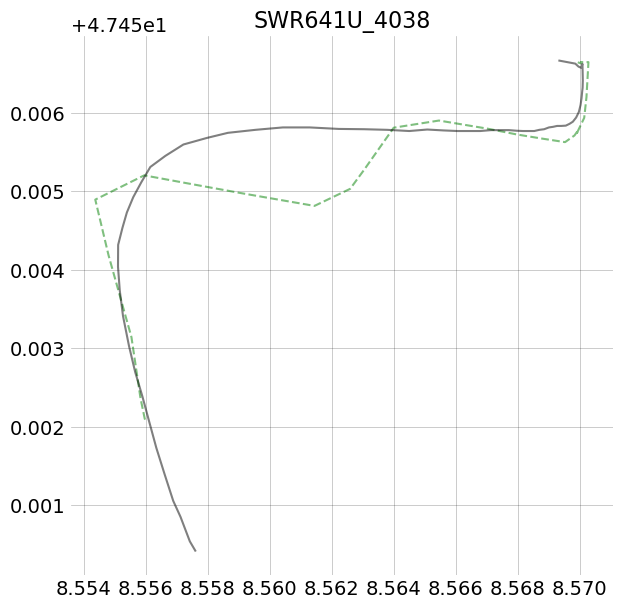

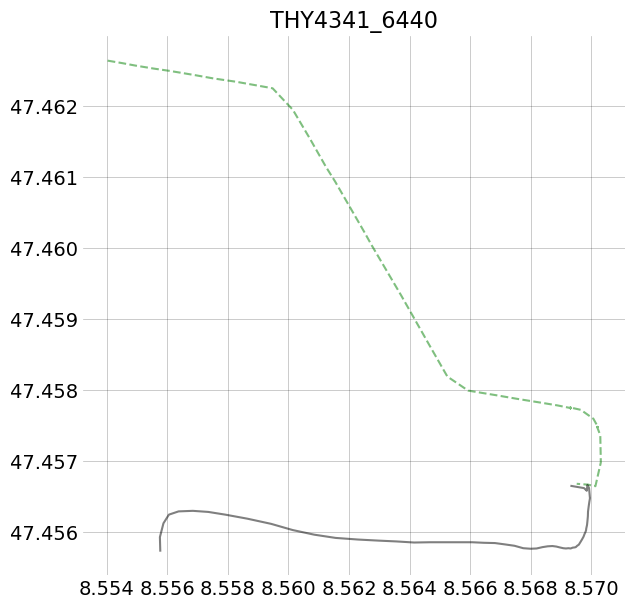

[<Figure size 700x700 with 1 Axes>,
 <Figure size 700x700 with 1 Axes>,
 <Figure size 700x700 with 1 Axes>,
 <Figure size 700x700 with 1 Axes>,
 <Figure size 700x700 with 1 Axes>]

In [91]:
plot_reconstruction(flight_selection, t_f, model, show_plots=True)

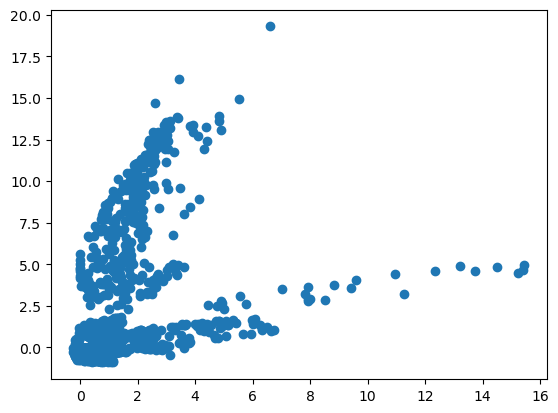

In [92]:
# latent = get_latent(X, model, device)
model.eval()
latent = get_latent(X, model, device)

%matplotlib inline
# %matplotlib widget
# %matplotlib ipympl

# plt.interactive(True)

fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
# ax.scatter(latent[:, 0], latent[:, 1],c=latent[:, 2])
# ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2])
ax.scatter(latent[:, 0], latent[:, 1])
plt.show()

In [209]:
t_f

,count
flight_id,
AAL93_7720,64
SWR25P_4024,64
SWR252H_6245,64
SWR252H_6246,64
SWR2530_3232,64
SWR253J_1323,64
SWR253J_1371,64
SWR253J_1539,64
SWR253J_1743,64


In [93]:
flights_ids = t_f.flight_ids

In [70]:
%matplotlib inline

-0.20158172 0.9575723
(64, 2)
SWR31K_2534


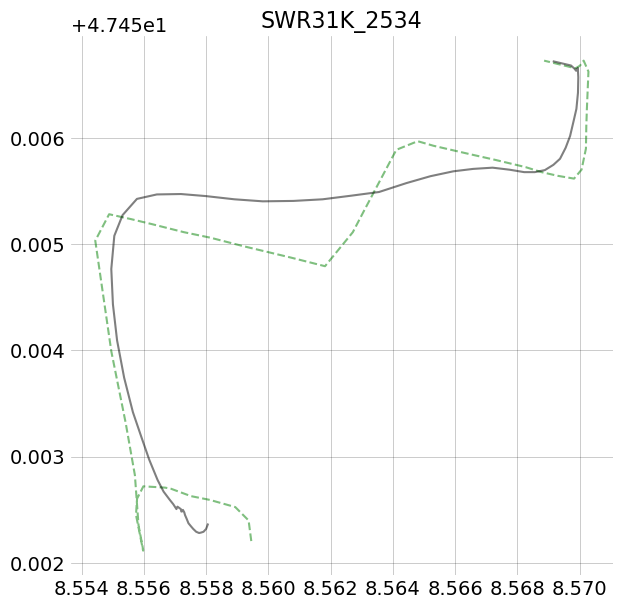

In [109]:
flight = t_f[np.random.choice(flights_ids, 1)]

flight_original = Flight(flight.data.copy())

flight_X = flight.data[list_features].values

flight_X = scaler.transform(flight_X)
flight_X = torch.as_tensor(flight_X.reshape(1, -1), dtype=torch.float32, device=device)

model.eval()
flight_Y = model(flight_X)[1].cpu().detach().numpy()
print(np.min(flight_Y), np.max(flight_Y))
flight_Y = scaler.inverse_transform(flight_Y.reshape(-1, len(list_features)))

flight_Y_reshaped = flight_Y.reshape(-1, len(list_features))

flight_reconstructed = Flight(flight.data.copy())
flight_reconstructed.data[list_features] = flight_Y_reshaped
print(flight_Y_reshaped.shape)

with plt.style.context("traffic"):  # type: ignore
    fig, ax = plt.subplots(figsize=(7, 7))

    flight_original.plot(ax, alpha=0.5, label="original", color="green", ls="--")
    flight_reconstructed.plot(ax, alpha=0.5, label="reconstructed", color="k")
    plt.title(f"{flight_original.flight_id}")
    print(flight_original.flight_id)
    plt.show()

# plt.scatter(
#     range(flight_original.data.shape[0]),
#     flight_original.data["groundspeed"],
#     color="green",
#     alpha=0.5,
#     label="original",
#     ls="--",
# )
# plt.scatter(
#     range(flight_original.data.shape[0]),
#     flight_reconstructed.data["groundspeed"],
#     color="k",
#     alpha=0.5,
#     label="reconstructed",
#     ls="--",
# )
# plt.show()

In [119]:
features_, _ = prepare_features_new(
    list_features=list_features, scaler=scaler, traffic=t_f, flight_idx=np.random.choice(flights_ids, 10)
)

In [120]:
features_.shape

(10, 128)

In [128]:
X, ids = prepare_features_new(
    list_features=list_features, scaler=scaler, traffic=t_f
)

model.eval()
latent = model.encoder(torch.tensor(X, dtype=torch.float32))

In [ ]:
from sklearn.

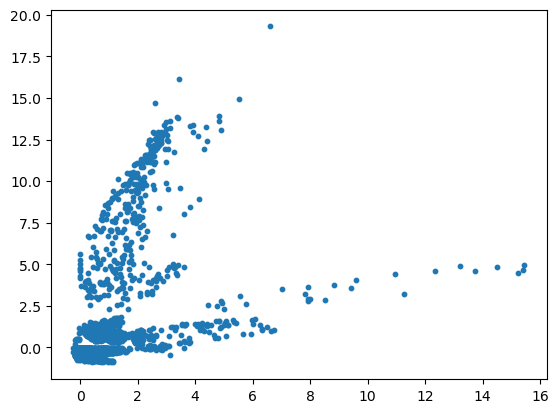

In [131]:
latent = latent.detach().cpu().numpy()
plt.scatter(latent[:, 0], latent[:, 1], s=10)

In [183]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.8, min_samples=5).fit(X)
clusters = clustering.labels_
np.unique(clustering.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

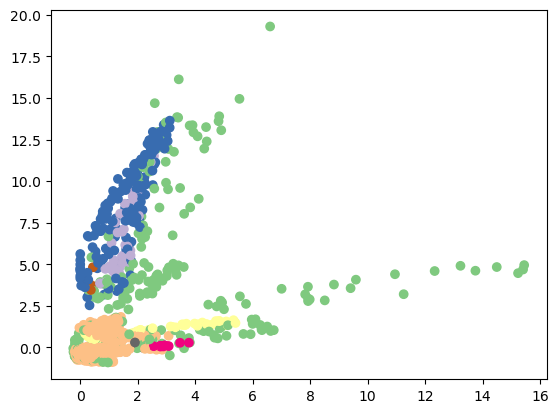

In [186]:
plt.scatter(latent[:, 0], latent[:, 1], c=[colormap(c+1) for c in clusters])

In [156]:
import matplotlib as mpl

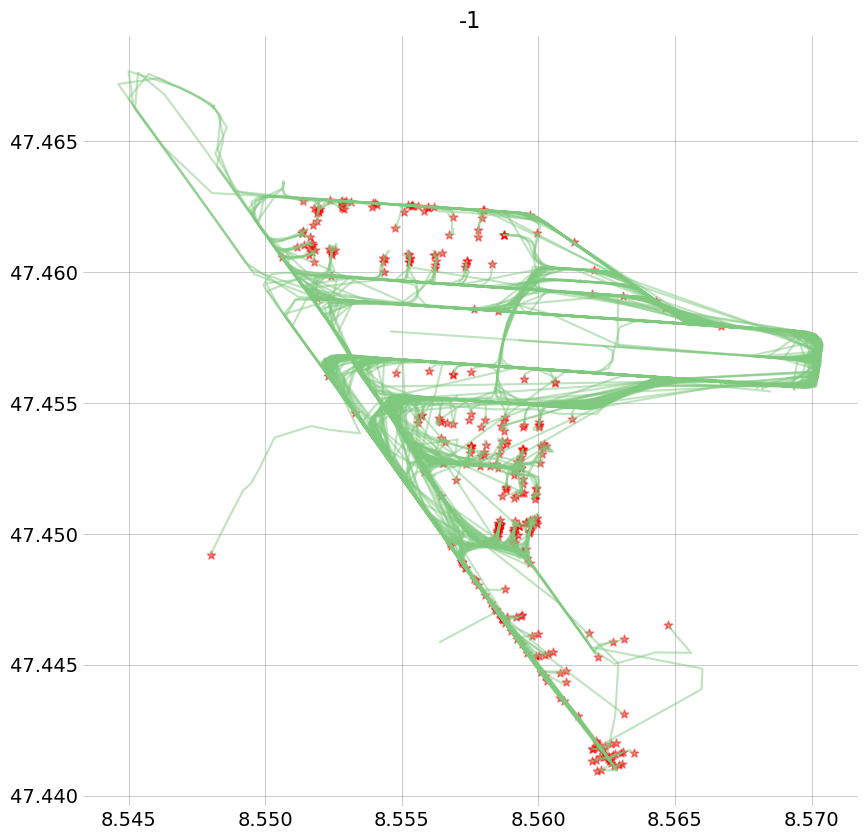

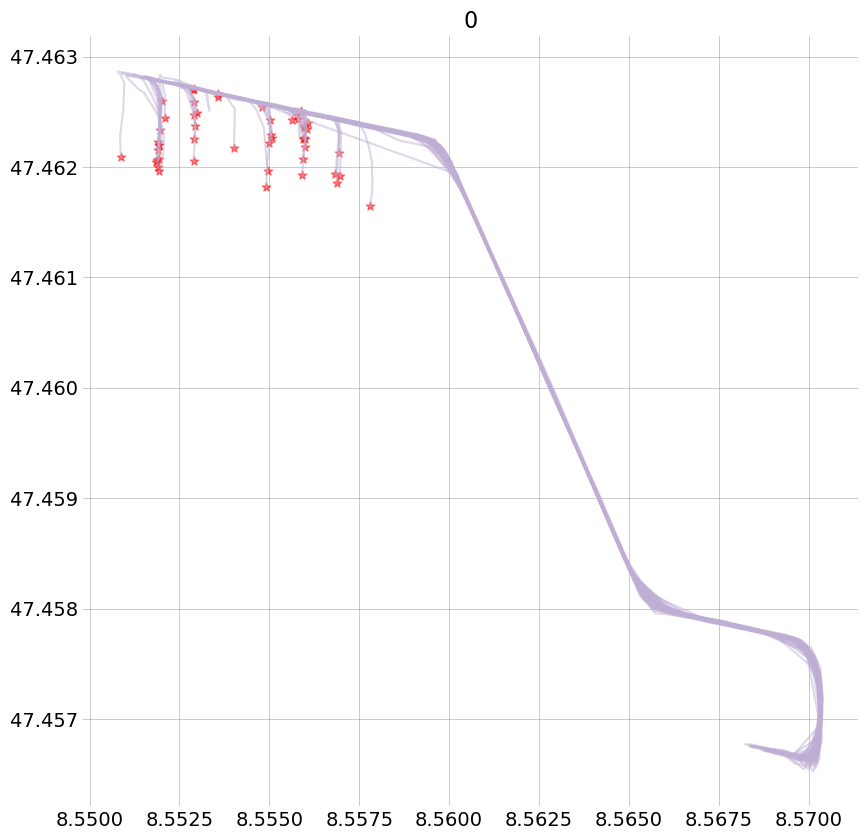

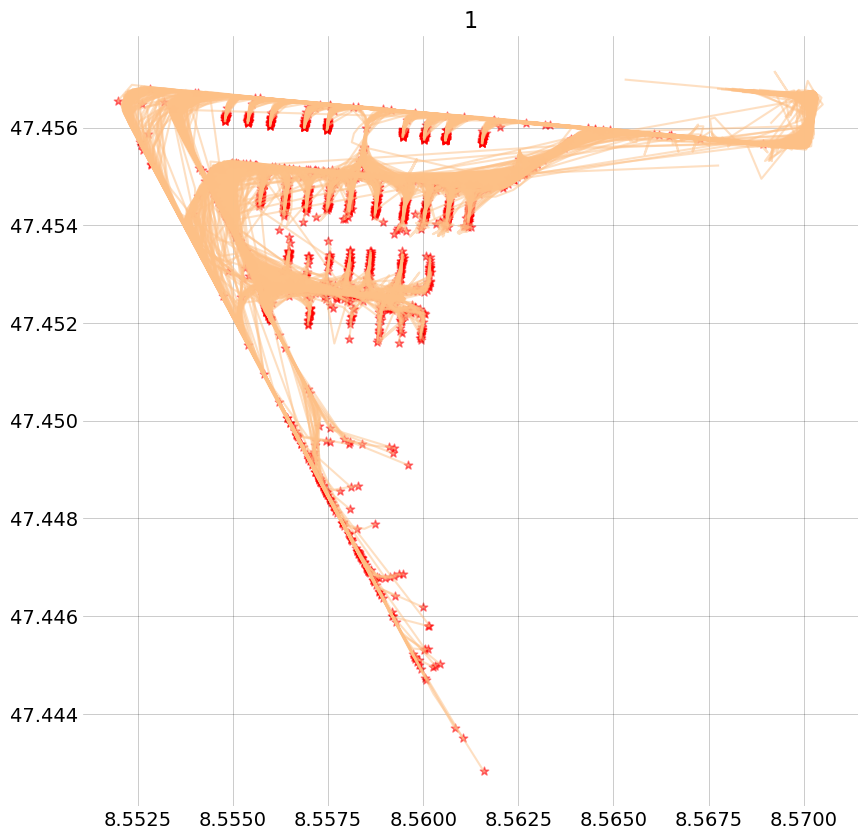

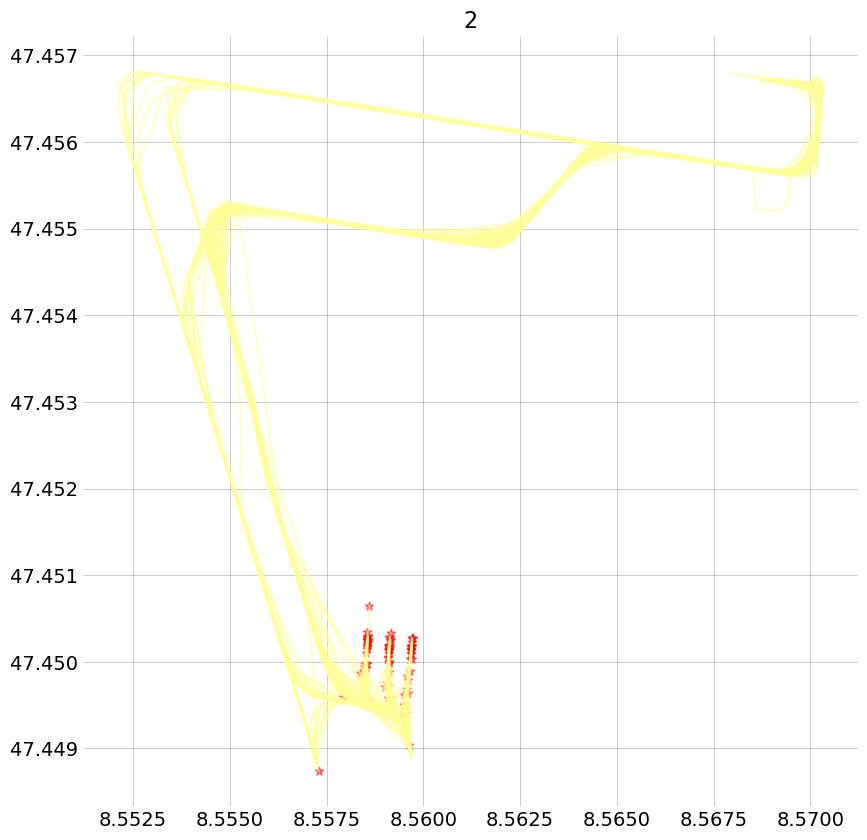

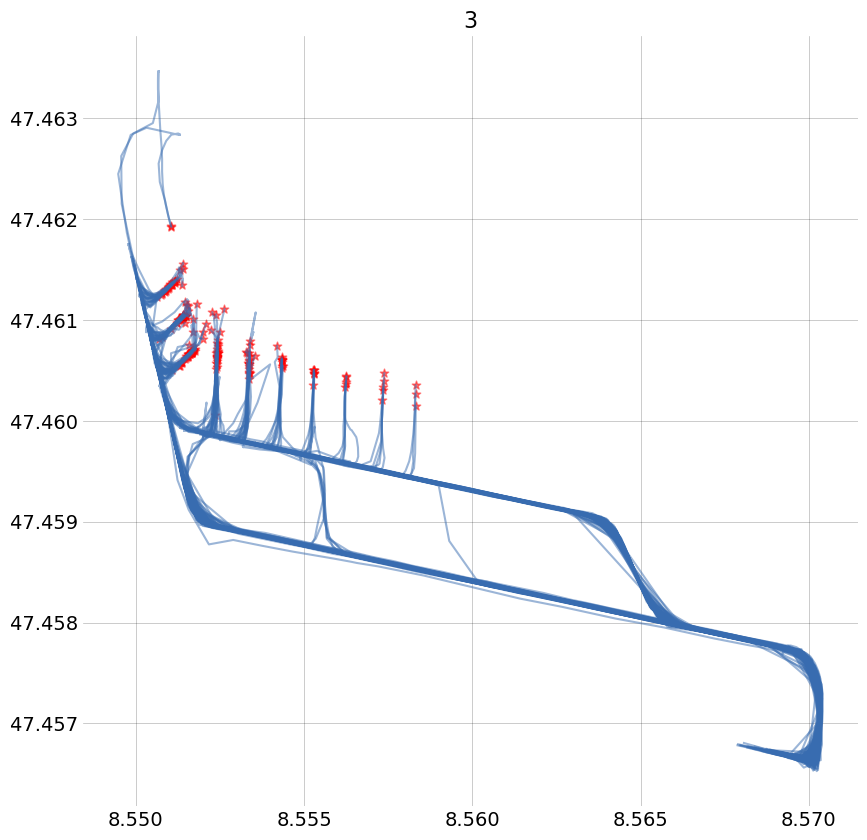

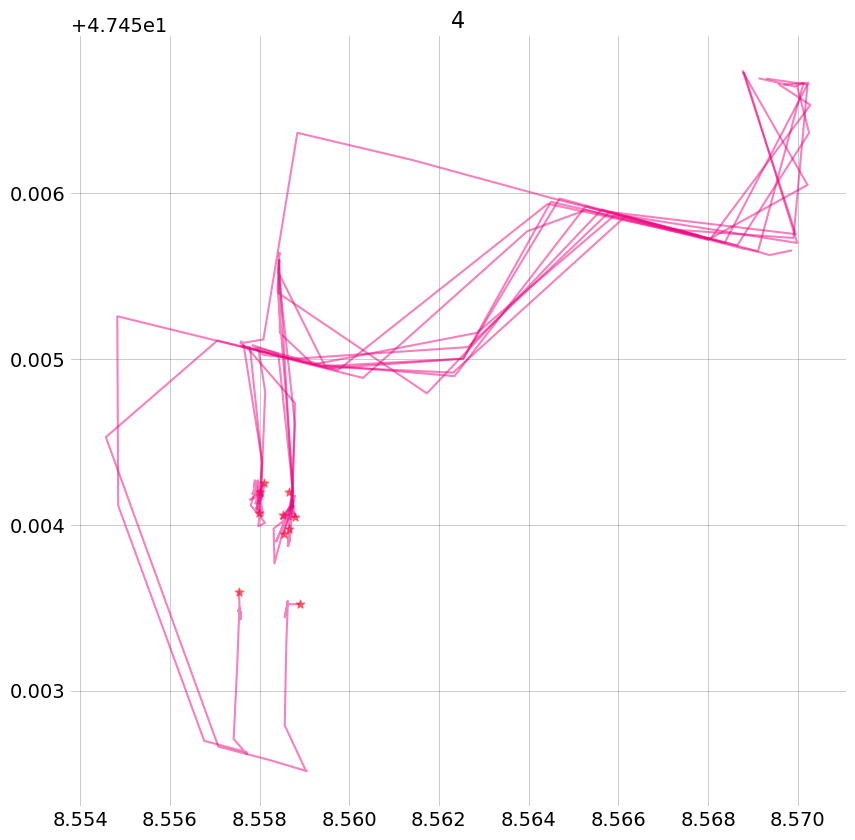

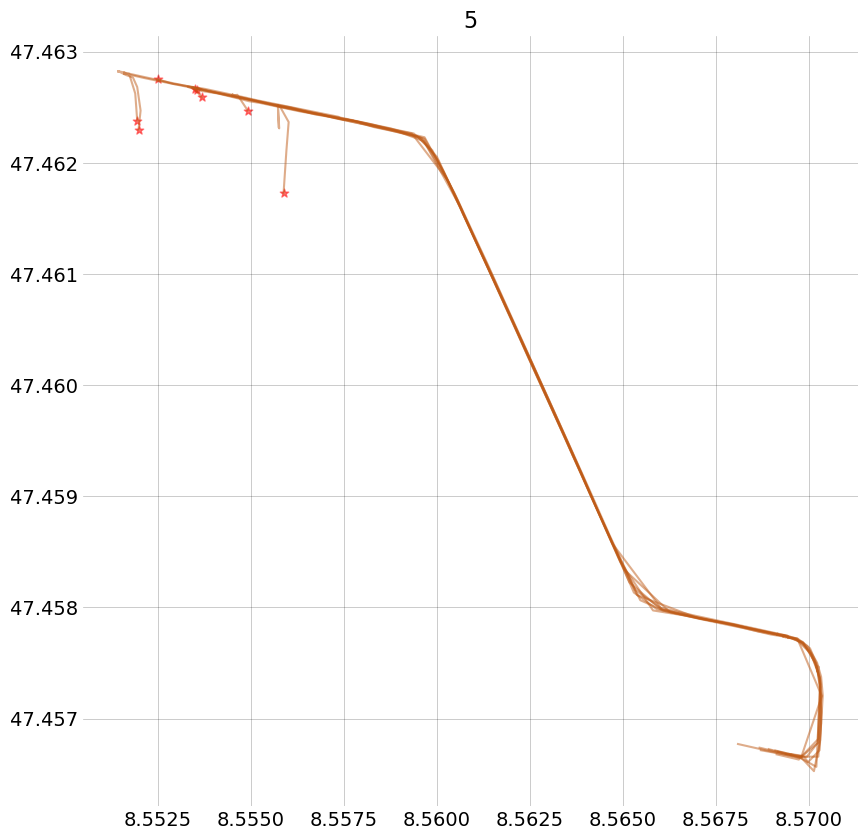

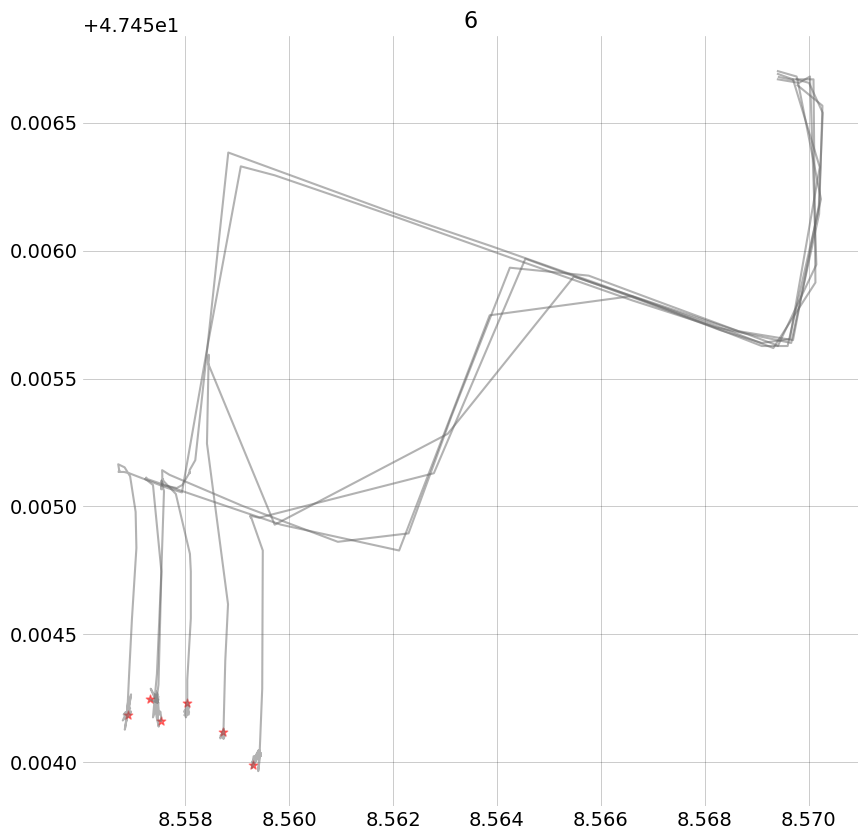

In [187]:
colormap = mpl.colormaps["Accent"]

for cluster_ in np.unique(clusters):
    with plt.style.context("traffic"):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(cluster_)

        for cluster, flight_id in zip(clusters, ids):
            if cluster != cluster_:
                continue
            flight = t_f[flight_id]
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.5,
            )
            flight.plot(ax=ax, alpha=0.5, color=colormap(cluster+1))
        
        plt.show()

In [188]:
from sklearn.cluster import HDBSCAN

clustering = HDBSCAN(min_cluster_size=20).fit(X)
# clustering.predict(X)
clusters = clustering.labels_
np.unique(clustering.labels_)

array([-1,  0,  1,  2])

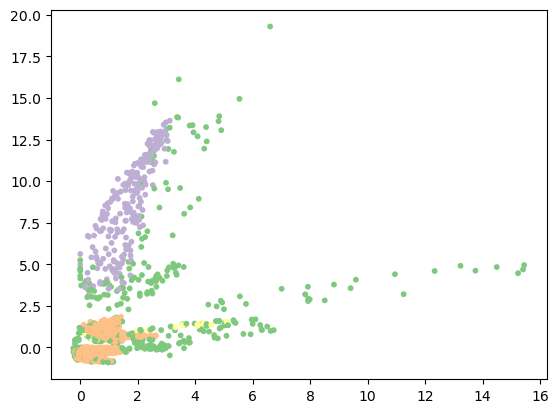

In [189]:
plt.scatter(latent[:, 0], latent[:, 1], c=[colormap(cluster + 1) for cluster in clusters], s=10)

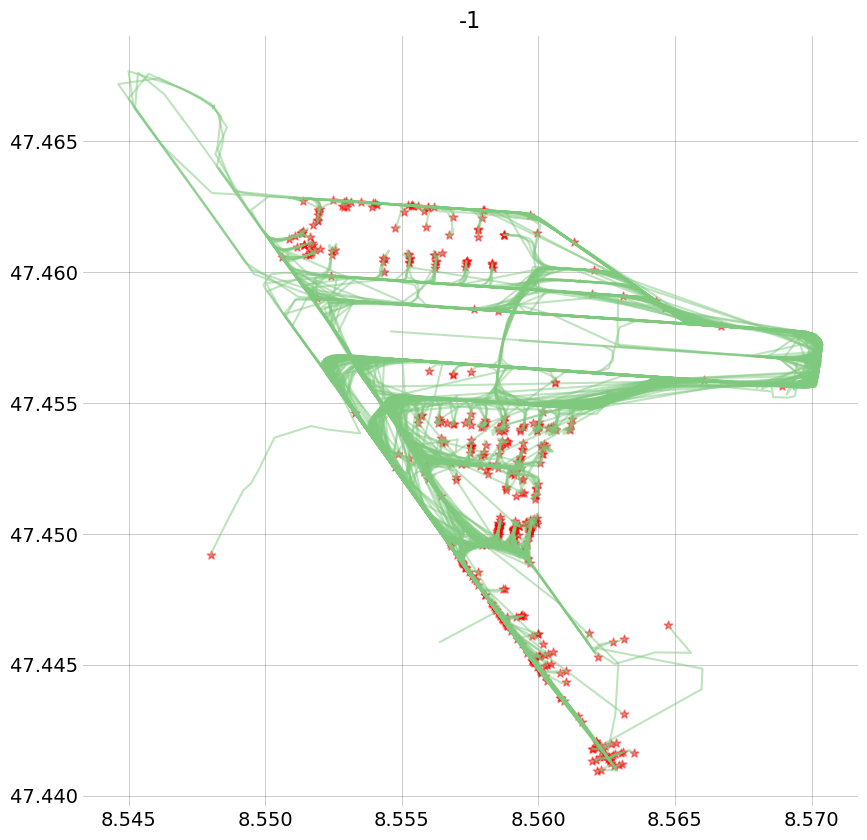

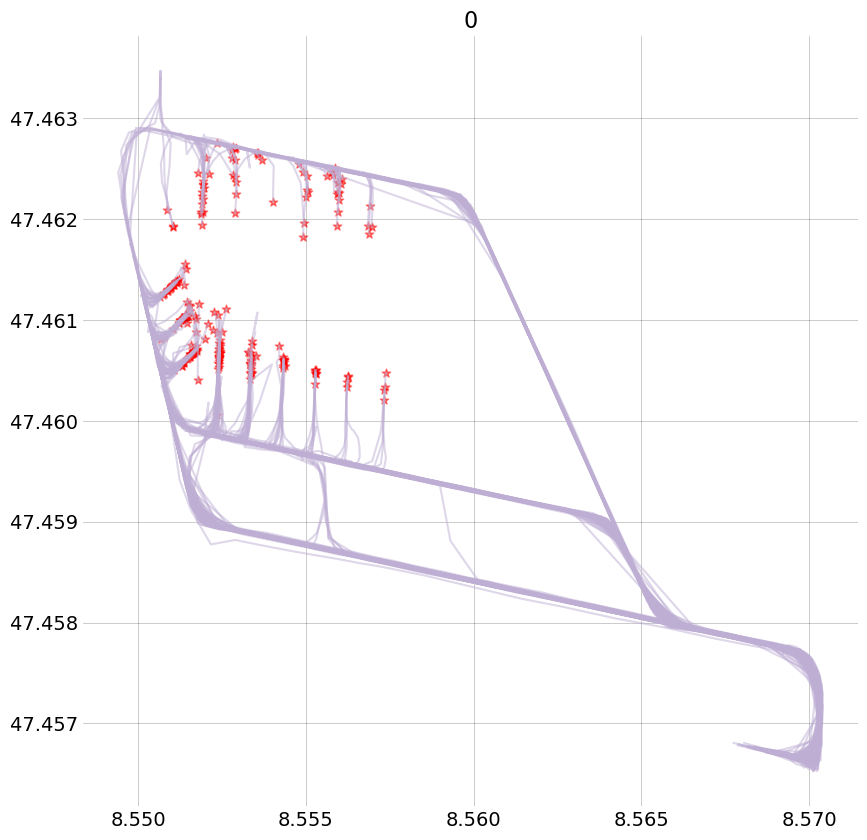

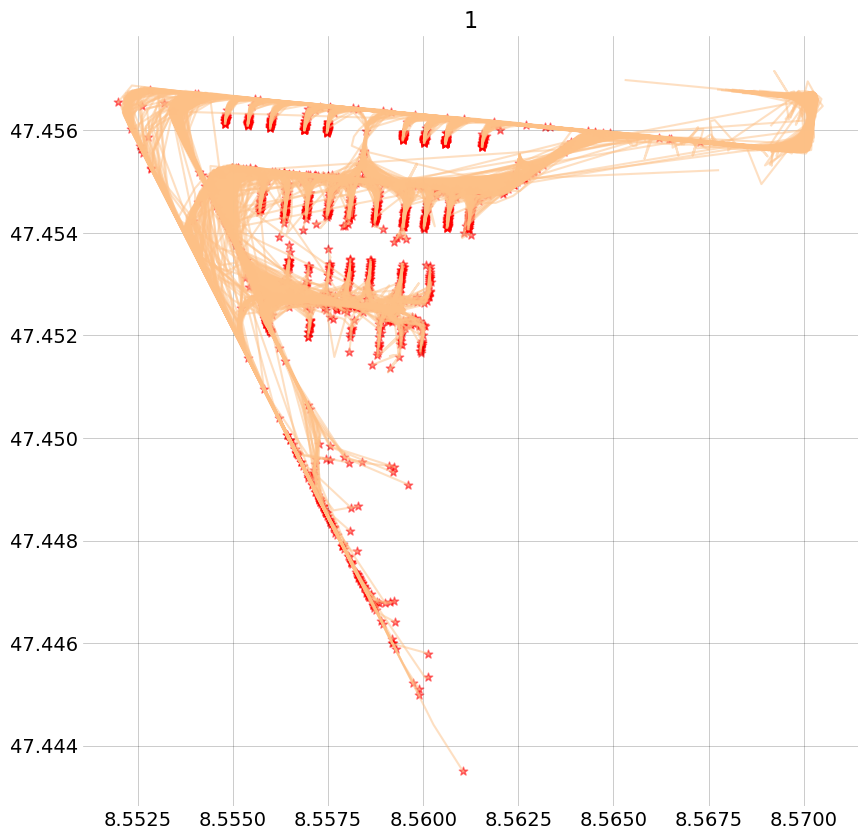

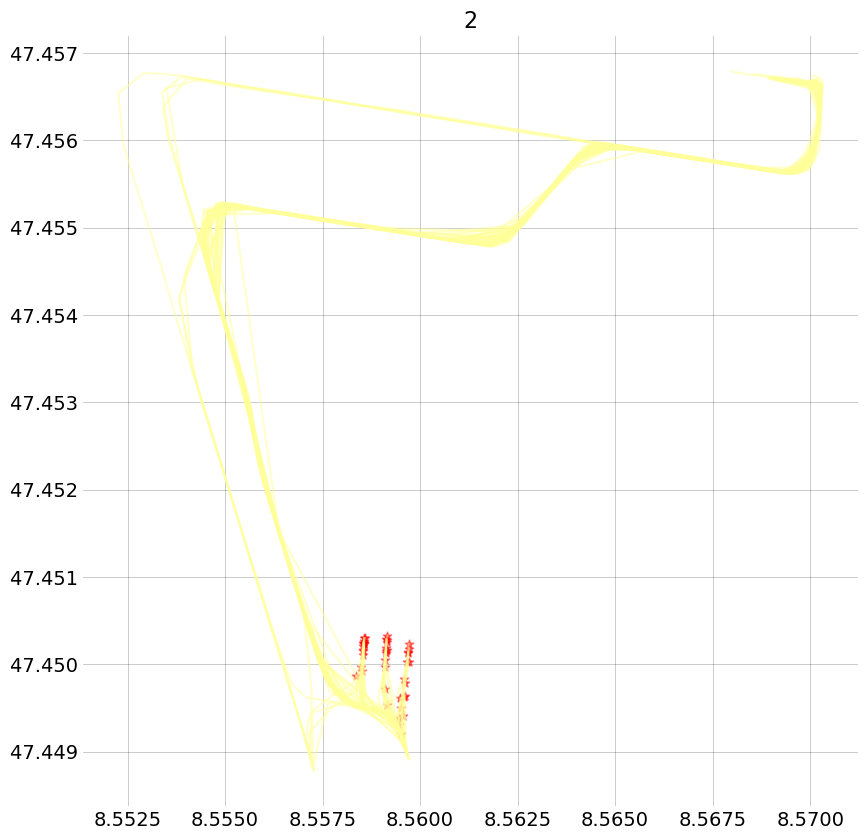

In [190]:
colormap = mpl.colormaps["Accent"]

for cluster_ in np.unique(clusters):
    with plt.style.context("traffic"):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(cluster_)

        for cluster, flight_id in zip(clusters, ids):
            if cluster != cluster_:
                continue
            flight = t_f[flight_id]
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.5,
            )

            flight.plot(ax=ax, alpha=0.5, color=colormap(cluster + 1))
        
        plt.show()